# Exploring ATAC-seq signal across Endothelial cell types

This workbook uses ATAC-seq from LSECs (Cebola lab), ECFC and HUVECs (Randi lab) and LEC (Birdsey lab).

Read in all CREs in order to count reads in peaks and normalize across datasets.

Use LSEC CREs but add any CREs from HDLEC, HUVEC or ECFC which are missing (as merged peaks):

```bash
LSECcres='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/LSEC_CREs.bed'
LECcres='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/LEC_CREs.bed'
HUVECcres='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/H-replicated-peaks-new.bed'
ECFCcres='/cd/CB-replicated-peaks-new.bed'
TV_ERG_CREs='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/ECs_ATAC/ERG_CREs.bed'

module load anaconda3/personal
source activate ATAC

cat ${LSECcres} ${LECcres} ${HUVECcres} ${ECFCcres} ${TV_ERG_CREs} | cut -f 1-3 | sort -k 1V,1 -k 2,2n | bedtools merge -i - > EC_CREs_merged_with_TV.bed
```

You will create a conda environment from the `diffbind.yml` file I have saved in the shared `cebola_lab_general` folder. The commented out commands below are for reference how I created the environment:
```bash 
#conda create -n diffbind mamba bioconda::bioconductor-diffbind bioconductor-complexheatmap
#source activate diffbind
#mamba install -c conda-forge r-tidyverse r-ggplot2 r-irkernel
#mamba install -c bioconda bioconductor-genomicranges bioconductor-annotationdbi bioconductor-org.hs.eg.db bioconductor-edger
#mamba install jupyter_client r-gridextra
```# Open R
R
# Install preprocessCore and disable threading
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("preprocessCore", configure.args="--disable-threading")
Update all packages
install.packages('gplots')

Run on the command line:
```bash
#module load anaconda3/personal
#conda env create -f /rds/general/project/cebola_lab_general/live/conda_envs/diffbind.yml
#source activate diffbind

```

To make the conda environment compatible with your VSCode, run:
```R
IRkernel::installspec(user = TRUE)
IRkernel::installspec(name = 'r-diffbind', displayname = 'R 4.3.3 (r-diffbind)')
quit()
```

```bash
#mamba install r-pheatmap
#conda env export > /rds/general/project/cebola_lab_general/live/conda_envs/diffbind.yml
```

In [1]:
# Set to your working directory and load libraries
setwd('/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap')

In [2]:
#BiocManager::install("preprocessCore", configure.args="--disable-threading", force = TRUE)
#BiocManager::install("limma")
library(DiffBind)
library(tidyverse)
library(ComplexHeatmap)
library(ggplot2)
library(GenomicRanges)
library(gridExtra)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(pheatmap)
library(preprocessCore)
library(gplots)
library(dplyr)
library(limma)
library(RColorBrewer)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

Note, to see the manual for a command, type: `?makeGRangesFromDataFrame`

In [3]:
# Read the peaks into R and convert to a GRanges object
peaks <- read.table('EC_CREs_merged.bed')
colnames(peaks) <- c('chr','start','end')
peaks <- makeGRangesFromDataFrame(peaks)

You should have edited the `DiffBind_sampleSheet.txt` to contain the paths to the bam files (currently the paths are for directories you cannot access).

In [3]:
# Read in the sample sheet required for DiffBind
dbObj <- dba(sampleSheet='DiffBind_sampleSheet.txt')
dbObj

LEC_rep1 LEC batch1 control  1 macs

LEC_rep2 LEC batch1 control  2 macs

LSEC_061818 LSEC batch1 control  3 macs

LSEC_180811 LSEC batch1 control  4 macs

LSEC_6110 LSEC batch1 control  5 macs

CB4 ECFC batch1 control  6 macs

CB9 ECFC batch1 control  7 macs

CB11 ECFC batch1 control  8 macs

CB7 ECFC batch1 control  9 macs

H8 HUVEC batch1 control  10 macs

H4 HUVEC batch1 control  11 macs

H9 HUVEC batch1 control  12 macs

H7 HUVEC batch1 control  13 macs

H11 HUVEC batch1 control  14 macs



14 Samples, 0 sites in matrix:
            ID Tissue Factor Condition Replicate
1     LEC_rep1    LEC batch1   control         1
2     LEC_rep2    LEC batch1   control         2
3  LSEC_061818   LSEC batch1   control         3
4  LSEC_180811   LSEC batch1   control         4
5    LSEC_6110   LSEC batch1   control         5
6          CB4   ECFC batch1   control         6
7          CB9   ECFC batch1   control         7
8         CB11   ECFC batch1   control         8
9          CB7   ECFC batch1   control         9
10          H8  HUVEC batch1   control        10
11          H4  HUVEC batch1   control        11
12          H9  HUVEC batch1   control        12
13          H7  HUVEC batch1   control        13
14         H11  HUVEC batch1   control        14

Save the objects into the working directory.

In [5]:
save(dbObj, file='dbObj')
save(peaks,file='peaks')

Next, run `qsub submit_dbaCount.sh`. This will run the `dba.count` step as a script (saved in `dbacount.R`). This take a lot of memory!!

```R
# dbObj <- dba.count(dbObj, bUseSummarizeOverlaps=TRUE,summits=100,peaks=peaks, bParallel=TRUE) #DBA_NORM_DEFAULT
```

Load the script output, which is the count matrix from the input peaks across the input bam files.

In [4]:
# Load the counted object
load('dbObj_with_TV_CREs.counted')

Normalise the counted reads.
The default normalization parameters are as follows (read the DiffBind manual for reference):
- `normalize=DBA_NORM_LIB`
- `library=DBA_LIBSIZE_FULL`
- `background=FALSE`

Since the background noise is different for all samples, instead use `library = DBA_LIBSIZE_PEAKREADS`

In [5]:
#dba.peakset(tamoxifen, bRetrieve=TRUE) # default: DBA_SCORE_NORMALIZED
dbObj.counted <- dba.normalize(dbObj.counted, library = DBA_LIBSIZE_PEAKREADS)

In [6]:
normCounts <- dba.peakset(dbObj.counted, bRetrieve=TRUE, DataType=DBA_DATA_FRAME)
normCounts.qn <- normCounts
normCounts.qn[,4:ncol(normCounts)] <- limma::normalizeQuantiles(as.matrix(normCounts.qn[,4:ncol(normCounts)]))

Extract the peak counts and run quantile normalisation. 

In [7]:
# What is the total read count for all samples?
apply(normCounts[,4:ncol(normCounts)], 2, sum)

LEC_rep1    LEC_rep2 LSEC_061818 LSEC_180811   LSEC_6110         CB4 
    7134041     7134041     7134041     7134041     7134041     7134041 
        CB9        CB11         CB7          H8          H4          H9 
    7134041     7134041     7134041     7134041     7134041     7134041 
         H7         H11 
    7134041     7134041

Counts before and after quantile normalisation.

Warning message:
“Removed 39121 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 39121 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 1123 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 1123 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


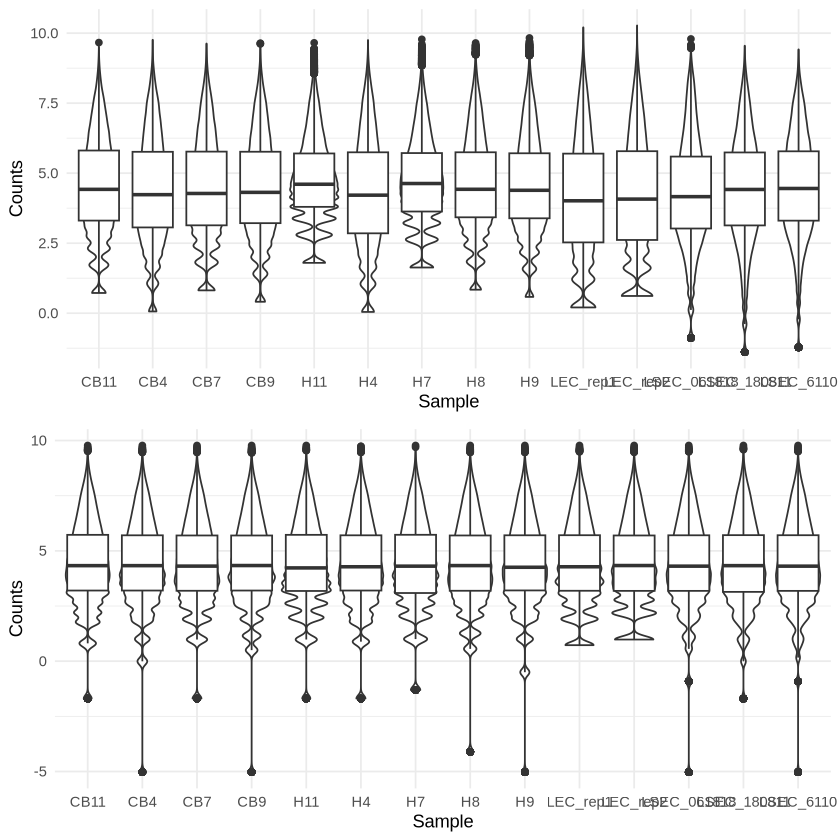

In [8]:
plot1 <- normCounts[,4:ncol(normCounts)] %>% 
	 pivot_longer(., everything(), names_to = "Sample", values_to = "Counts") %>%
	 ggplot(., aes(x=Sample, y = log2(Counts))) + geom_violin() + geom_boxplot() + labs(x = 'Sample', y = 'Counts') +
	 theme_minimal()

# Quantile normalised - limma
plot2 <- normCounts.qn[,4:ncol(normCounts)] %>% 
	 pivot_longer(., everything(), names_to = "Sample", values_to = "Counts") %>%
	 ggplot(., aes(x=Sample, y = log2(Counts))) + geom_violin() + geom_boxplot() + labs(x = 'Sample', y = 'Counts') +
	 theme_minimal()

box_violin <- grid.arrange(plot1,plot2)



In [68]:
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38380036 & START < 38498477) #ERG Gene Body
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38400000 & START < 39440000) #ERG TAD
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 37706576 & START < 39397150) #Extended TAD
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38397808 & START < 38518355) #Sub TAD
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38494247 & START < 39200000) #Foucsed TAD

head(ERG.counts)
ERG.counts %>% dim #to see how many regions have been selected 

,CHR,START,END,LEC_rep1,LEC_rep2,LSEC_061818,LSEC_180811,LSEC_6110,CB4,CB9,CB11,CB7,H8,H4,H9,H7,H11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
88365,chr21,38494734,38494934,82.89371,81.74139,66.690621,62.062996,73.497560,115.679806,85.172732,99.591321,116.003323,146.199763,129.774250,172.336572,96.498690,118.15317
88366,chr21,38496317,38496517,50.06523,31.73167,21.069731,11.668198,12.958592,22.117304,30.360663,29.323795,26.675028,12.693382,33.961143,31.555859,16.420744,18.73517
88367,chr21,38499298,38499498,66.76005,69.85583,97.168559,61.504274,153.084731,151.438575,155.779397,181.319640,146.029349,129.236179,172.750895,161.025220,135.936467,130.04197
88368,chr21,38503624,38503824,71.04310,64.29514,88.929180,42.519412,106.683408,115.679806,110.443802,90.448643,105.435030,112.485219,129.122820,124.691990,49.204174,57.00924
88369,chr21,38505721,38505921,82.89371,119.33726,77.149779,58.138550,81.335504,100.595871,106.269084,103.342763,103.412197,119.684094,117.676350,95.636261,53.015359,122.10786
88370,chr21,38538404,38538604,23.84940,34.95294,4.608013,8.823217,6.514611,5.854353,1.415161,3.401731,7.199121,4.232766,4.385534,2.004709,2.004709,3.94200


[1] 85 17

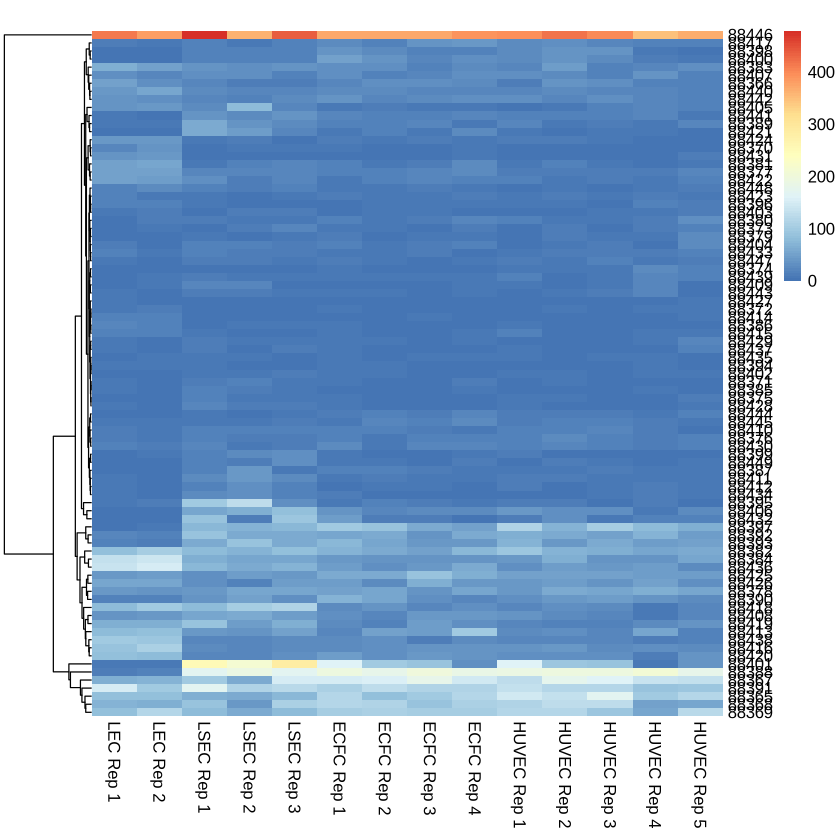

In [70]:
# Plot the heatmap with the NO ROW SCALING to show scalign is needed
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5") # Adjust this vector to match the number of columns

heatmap <- pheatmap(ERG.counts[,4:ncol(ERG.counts)], 
	border_color = NA, main = "",
  	show_rownames = TRUE, show_colnames = TRUE, kmeans_k = NA, # 4,
  	cluster_rows = T, cluster_cols = F, labels_col = new_labels)


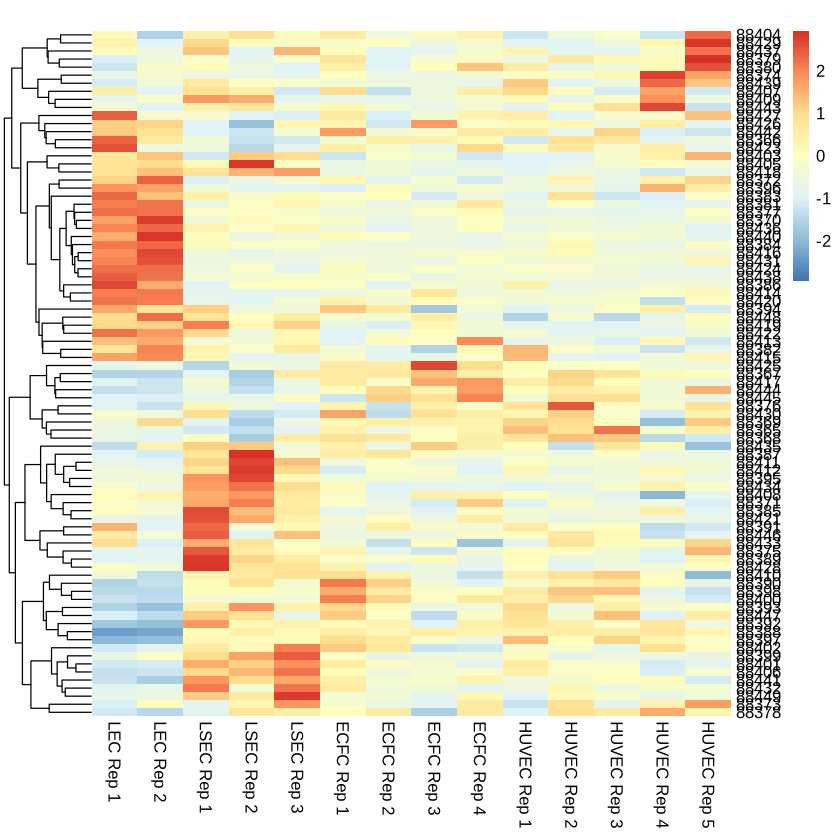

In [71]:
# Plot the heatmap with the new column labels
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5") # Adjust this vector to match the number of columns

heatmap <- pheatmap(ERG.counts[,4:ncol(ERG.counts)], 
	border_color = NA, main = "",scale='row',
  	show_rownames = TRUE, show_colnames = TRUE, kmeans_k = NA, # 4,
  	cluster_rows = T, cluster_cols = F, labels_col = new_labels)

In [27]:
# Scale the dataframe by column to see you need row scaling
#first_three_cols <- ERG.counts[, 1:3]
#scaled_columns <- scale(ERG.counts[, 4:ncol(ERG.counts)])
#vals <- bind_cols(first_three_cols, as.data.frame(scaled_columns))


In [72]:
# Scale the dataframe by row
vals <- ERG.counts[,1:3] %>% bind_cols(
	t(scale(t(as.matrix(ERG.counts[,4:ncol(ERG.counts)]))))
)
vals

,CHR,START,END,LEC_rep1,LEC_rep2,LSEC_061818,LSEC_180811,LSEC_6110,CB4,CB9,CB11,CB7,H8,H4,H9,H7,H11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
88365,chr21,38494734,38494934,-0.64449737,-0.68087898,-1.15607209,-1.30217854,-0.94115885,0.39064721,-0.572542513,-0.117309174,0.40086150,1.354243724,0.83564643,2.179452515,-0.21495180,0.46873793
88366,chr21,38496317,38496517,2.37140328,0.64015201,-0.36666295,-1.25445655,-1.13260375,-0.26773981,0.510686624,0.412774484,0.16264939,-1.157647672,0.85068259,0.623549877,-0.80567018,-0.58711736
88367,chr21,38499298,38499498,-1.56827603,-1.49079834,-0.80724523,-1.69981195,0.59216360,0.55096540,0.659602729,1.298796023,0.41558921,-0.004691902,1.08434683,0.790889463,0.16299559,0.01547460
88368,chr21,38503624,38503824,-0.67569991,-0.90919398,-0.05680301,-1.66268114,0.55753158,0.86882637,0.687649343,-0.004226317,0.51433504,0.758286777,1.33398366,1.180667380,-1.43137394,-1.16130185
88369,chr21,38505721,38505921,-0.57458581,1.05332863,-0.83116413,-1.68038586,-0.64418998,0.21616057,0.469580054,0.338862825,0.34196439,1.068821532,0.97913666,-0.005382642,-1.90923613,1.17708989
88370,chr21,38538404,38538604,1.65655778,2.82333205,-0.36535347,0.07758589,-0.16500556,-0.23438634,-0.700862673,-0.492111204,-0.09307633,-0.404784956,-0.38873185,-0.638912144,-0.63891214,-0.43533905
88371,chr21,38544779,38544979,-0.07453532,-0.40569602,1.61272777,2.06222393,0.58008790,-0.08131987,-0.601431404,-1.101711185,1.19730035,-0.939734778,-0.07453532,-0.615848971,-0.51118706,-1.04634001
88372,chr21,38562224,38562424,1.11256509,2.40420590,-1.04958611,-0.68714148,-0.30090515,0.28787698,-0.827566134,-0.328397428,-1.10553097,-0.579431742,0.29473182,-0.679429380,0.36061046,1.09799815
88373,chr21,38596352,38596552,-1.00122351,-0.02098888,-0.84618651,0.28949113,1.87091109,-0.20186765,-0.676497690,-0.846186510,0.63724250,-1.250801464,0.82420114,-0.831062689,0.30723539,1.74573366


Trying with the kmeans clustering so you can specify the number of clusters:

'data.frame':	85 obs. of  14 variables:
 $ LEC_rep1   : num  -0.644 2.371 -1.568 -0.676 -0.575 ...
 $ LEC_rep2   : num  -0.681 0.64 -1.491 -0.909 1.053 ...
 $ LSEC_061818: num  -1.1561 -0.3667 -0.8072 -0.0568 -0.8312 ...
 $ LSEC_180811: num  -1.3 -1.25 -1.7 -1.66 -1.68 ...
 $ LSEC_6110  : num  -0.941 -1.133 0.592 0.558 -0.644 ...
 $ CB4        : num  0.391 -0.268 0.551 0.869 0.216 ...
 $ CB9        : num  -0.573 0.511 0.66 0.688 0.47 ...
 $ CB11       : num  -0.11731 0.41277 1.2988 -0.00423 0.33886 ...
 $ CB7        : num  0.401 0.163 0.416 0.514 0.342 ...
 $ H8         : num  1.35424 -1.15765 -0.00469 0.75829 1.06882 ...
 $ H4         : num  0.836 0.851 1.084 1.334 0.979 ...
 $ H9         : num  2.17945 0.62355 0.79089 1.18067 -0.00538 ...
 $ H7         : num  -0.215 -0.806 0.163 -1.431 -1.909 ...
 $ H11        : num  0.4687 -0.5871 0.0155 -1.1613 1.1771 ...


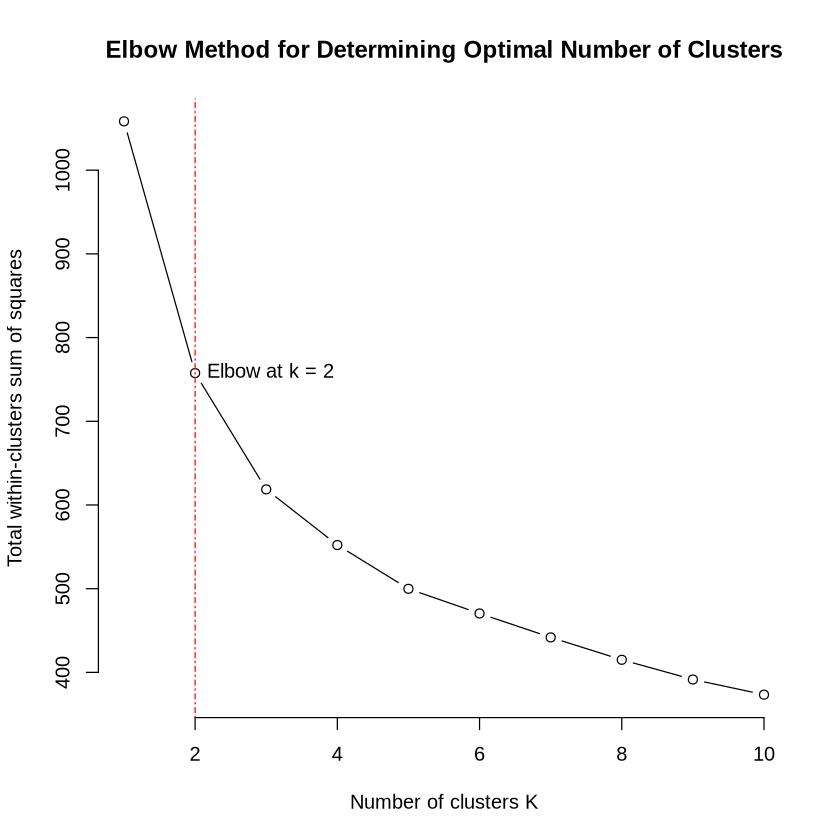

In [76]:

#Find the number of clusters for Kmeans 
vals_numeric <- subset(vals, select = -c(1, 2, 3))
str(vals_numeric)

#Create elbow plot to determine ho wmany clusters to use for Kmeans

wss <- 0

# For 1 to 10 cluster centers
for (i in 1:10) {
  km.out <- kmeans(vals_numeric, centers = i, nstart = 20, iter.max = 50)
   #Save total within sum of squares to wss variable
  wss[i] <- km.out$tot.withinss
}

find_elbow <- function(wss) {
  n <- length(wss)
  x <- 1:n
  # Fit a second-order polynomial (quadratic) to the WSS values
  fit <- lm(wss ~ poly(x, 2, raw = TRUE))
  # The elbow point is where the second derivative is the largest (most negative)
  elbow_point <- which.max(abs(diff(fit$residuals, differences = 2)))
  return(elbow_point+1)  # +1 to adjust for the index offset
}

elbow <- find_elbow(wss)

# Plot the WSS with the elbow point
elbow_plot <- plot(1:10, wss, type = "b", frame = FALSE,
     xlab = "Number of clusters K",
     ylab = "Total within-clusters sum of squares",
     main = "Elbow Method for Determining Optimal Number of Clusters")
abline(v = elbow, col = "red", lty = 4)
text(elbow, wss[elbow], labels = paste("Elbow at k =", elbow), pos = 4)


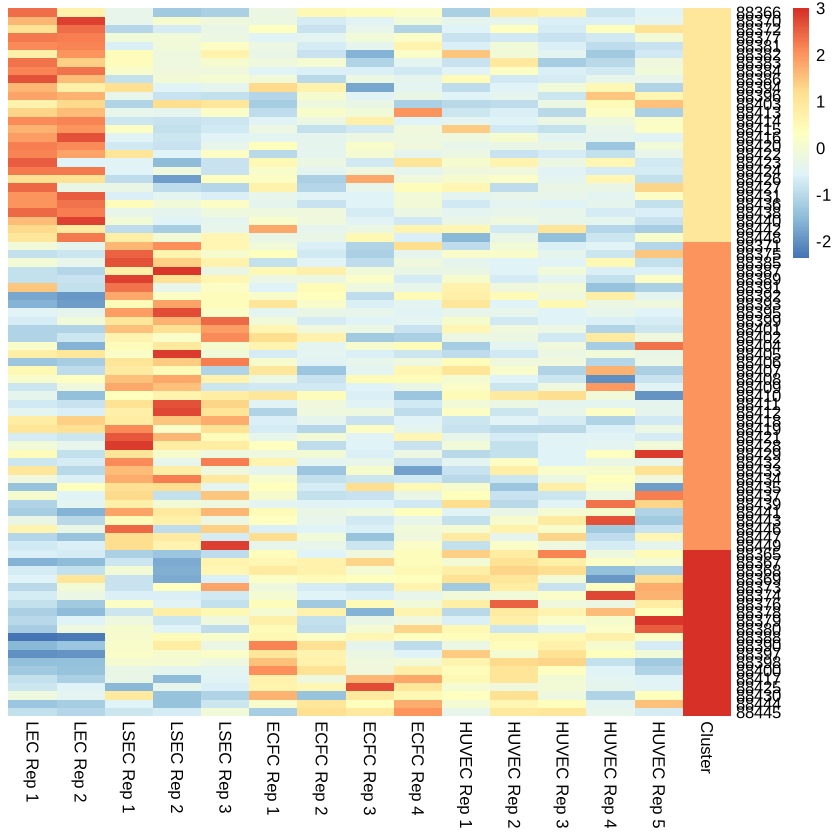

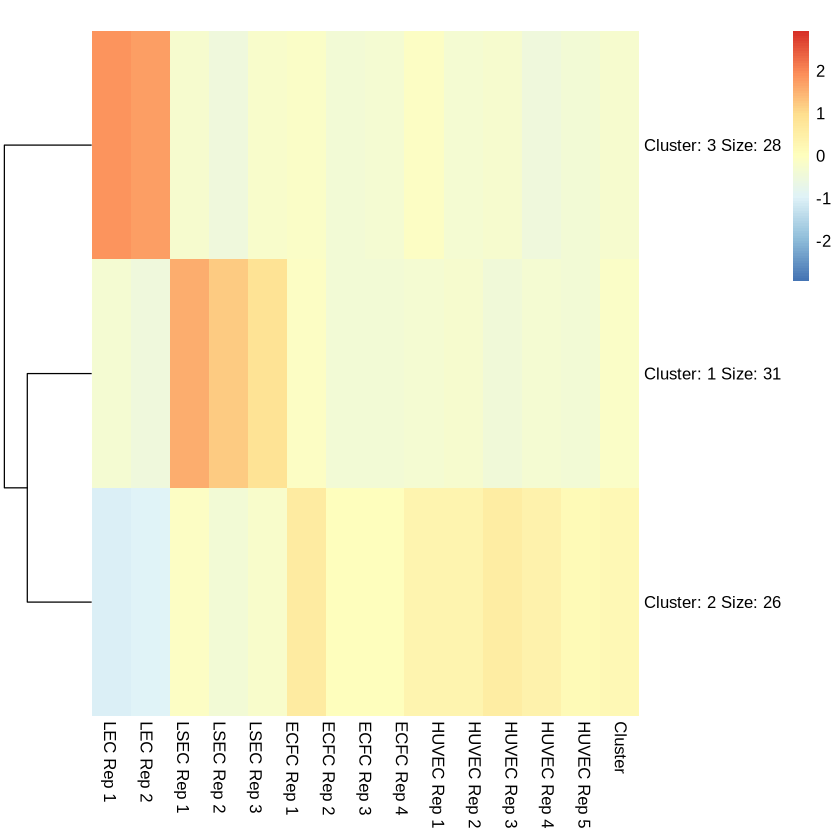

In [77]:
# k = 3
km = kmeans(vals[,4:ncol(vals)], 3) # The last value is the number of clusters. See what the plot looks like with different values
m2 <- cbind(vals,km$cluster)
o <- order(m2[, ncol(m2)])
m2 <- m2[o, ]
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5", "Cluster") # Adjust this vector to match the number of columns
#regions <- c("chr21:3843533-38435538", "chr21:38440834-38441034", "chr21:38460308-38460508", "chr21:38470883-38471083", "chr21:38472168-38472368", "chr21:38474156-38474356", "chr21:38476461-38476661", "chr21:38478813-38479013", "chr21:38483871-38484071", "chr21:38486326-38486526", "chr21:38494734-38494934", "chr21:38384148-38384348", "chr21:38388920-38389120", "chr21:38397973-38398173", "chr21:38401663-38401863", "chr21:38403182-38403382", "chr21:38408169-38408369", "chr21:38410483-38410683", "chr21:38424385-38424585", "chr21:38438543-38438743", "chr21:38443139-38443339", "chr21:38448111-38448311", "chr21:38455499-38455699", "chr21:38478093-38478293", "chr21:38484666-38484866", "chr21:38488871-38489071", "chr21:38496317-38496517")
kmeans <- pheatmap(m2[,4:ncol(m2)], border_color = NA, cluster_rows=F,cluster_cols=F,labels_col = new_labels)

#cluster
heatmap <- pheatmap(vals[,4:ncol(vals)], 
	border_color = NA, main = "",scale='row',
  	show_rownames = TRUE, show_colnames = TRUE, kmeans_k = 3, # 4,
  	cluster_rows = T, cluster_cols = F, labels_col = new_labels)




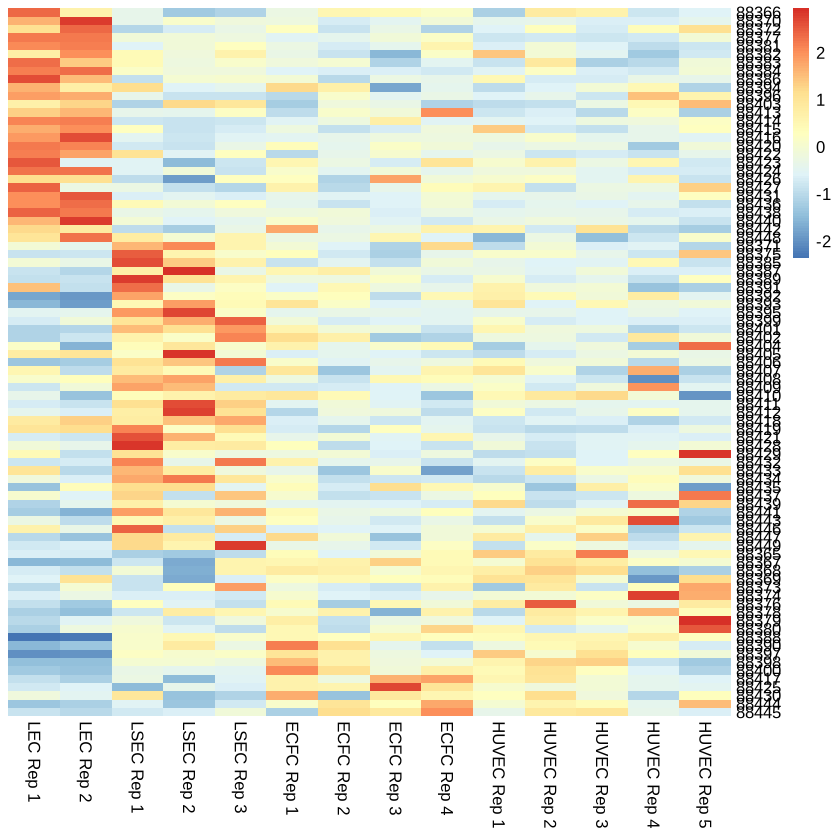

In [78]:
#to remove cluster column 
cluster_column <- km$cluster
cluster_column_index <- which(names(m2) == "km$cluster")
m2_filtered <- m2[, -cluster_column_index]
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5") # Adjust this vector to match the number of columns
pheatmap(m2_filtered[, 4:ncol(m2_filtered)], border_color = NA, cluster_rows = FALSE, cluster_cols = FALSE, labels_col = new_labels)


In [79]:
m2 %>% dplyr::select('CHR','START','END',`km$cluster`) %>% subset(`km$cluster` == 1)
m2 %>% dplyr::select('CHR','START','END',`km$cluster`) %>% subset(`km$cluster` == 2)
m2 %>% dplyr::select('CHR','START','END',`km$cluster`) %>% subset(`km$cluster` == 3)
write.csv(m2,'/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/clusters.csv',row.names=FALSE)

,CHR,START,END,km$cluster
,<chr>,<dbl>,<dbl>,<int>
88366,chr21,38496317,38496517,1
88370,chr21,38538404,38538604,1
88372,chr21,38562224,38562424,1
88377,chr21,38669274,38669474,1
88381,chr21,38712167,38712367,1
88382,chr21,38734104,38734304,1
88383,chr21,38744220,38744420,1
88384,chr21,38755717,38755917,1
88386,chr21,38767138,38767338,1


,CHR,START,END,km$cluster
,<chr>,<dbl>,<dbl>,<int>
88371,chr21,38544779,38544979,2
88375,chr21,38645422,38645622,2
88385,chr21,38756921,38757121,2
88387,chr21,38768764,38768964,2
88389,chr21,38787695,38787895,2
88391,chr21,38805731,38805931,2
88392,chr21,38811267,38811467,2
88393,chr21,38817972,38818172,2
88395,chr21,38831625,38831825,2


,CHR,START,END,km$cluster
,<chr>,<dbl>,<dbl>,<int>
88365,chr21,38494734,38494934,3
88367,chr21,38499298,38499498,3
88368,chr21,38503624,38503824,3
88369,chr21,38505721,38505921,3
88373,chr21,38596352,38596552,3
88374,chr21,38622216,38622416,3
88376,chr21,38661198,38661398,3
88378,chr21,38679673,38679873,3
88379,chr21,38691686,38691886,3


In the terminal: To find the clusters in which my LEC CRE coordinates are use bed intersect.

intersectBed -u -a erg_extended_TAD_clusters.bed -b ERG_extended_TAD_reg_regions.bed > Overlapping_extended_Tad_regions_with_Clusters.bed

erg_extended_TAD_clusters.bed = the m2 data frame with ATAC signal coordinates and the correspoding cluster (data used to generate heatmaps)
ERG_extended_TAD_reg_regions.bed = the 56 CREs I found 
Overlapping_extended_Tad_regions_with_Clusters.bed = The output file consisting of the overlapping ATAC signal coordiantes and the cluster.

To create and output file with my LEC CRE cooridnates: 
intersectBed -u -a ERG_extended_TAD_reg_regions.bed -b  erg_extended_TAD_clusters.bed > Overlapping_extended_Tad_regions_with_Clusters.bed
